Adınız: Mert

Soyadınız:Gökce

Okul Numaranız:2212721057

GitHub Repo Bağlantısı: https://github.com/mertgokce07/CNN_siniflandirma

model3.ipynb

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os

DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/dataset"
print("DATA_DIR:", DATA_DIR)
print("Klasörler:", os.listdir(DATA_DIR))
print("ayakkabi örnek:", os.listdir(DATA_DIR + "/ayakkabi")[:3])
print("bot örnek:", os.listdir(DATA_DIR + "/bot")[:3])

DATA_DIR: /content/drive/MyDrive/Colab Notebooks/dataset
Klasörler: ['ayakkabi', 'bot']
ayakkabi örnek: ['IMG_1363.jpg', 'IMG_1367.jpg', 'IMG_1365.jpg']
bot örnek: ['IMG_1562.jpg', 'IMG_1558.jpg', 'IMG_1559.jpg']


In [ ]:
import os, shutil, random
from pathlib import Path

random.seed(42)
#Dosya Yolu Tanımlamaları
SRC = Path(DATA_DIR) #Kaynak verilerin bulunduğu ana klasör
OUT = Path("/content/dataset_split")  # Colab geçici alan (hızlı)
TRAIN = OUT / "train" #Hedef klasör (OUT) altında oluşturulacak üç alt klasör.
VAL   = OUT / "val" #Hedef klasör (OUT) altında oluşturulacak üç alt klasör.
TEST  = OUT / "test" #Hedef klasör (OUT) altında oluşturulacak üç alt klasör.

# temizle Kodun her çalıştırılışında eski sonuçları silmek için, hedef klasör (OUT) mevcutsa tamamen silinir
if OUT.exists():
    shutil.rmtree(OUT)

for p in [TRAIN, VAL, TEST]: #Her train, val ve test klasörünün içine alt klasör oluşturur ayakkabi ve bot
    (p / "ayakkabi").mkdir(parents=True, exist_ok=True)
    (p / "bot").mkdir(parents=True, exist_ok=True)

def split_class(class_name, train_ratio=0.70, val_ratio=0.15): #Veri setinin bölünme oranları
    files = [f for f in (SRC / class_name).iterdir() if f.suffix.lower() in [".jpg",".jpeg",".png"]] #Kaynak klasördeki (SRC) o anki sınıfın alt klasörünü işaret eder.Sadece geçerli görüntü dosyalarının yollarını içeren bir liste oluşturulur.

    random.shuffle(files)
    n = len(files) # n: Sınıftaki toplam dosya sayısı.
    n_train = int(n * train_ratio) #Toplam sayının %70'ini (Eğitim) temsil eden tamsayı adedi hesaplanır.
    n_val   = int(n * val_ratio) #Toplam sayının %15'ini (Doğrulama) temsil eden tamsayı adedi hesaplanır.

#Liste Dilimleme
    train_files = files[:n_train] #Listenin başından n_train sayısına kadar olan kısım.
    val_files   = files[n_train:n_train+n_val] # n_train'den başlayıp n_val eklenmiş noktaya kadar olan kısım.
    test_files  = files[n_train+n_val:] #Kalan tüm dosyalar (yaklaşık %15).

#Dosyaları Kopyalama  Her dosya, ait olduğu yeni klasöre (Eğitim, Doğrulama veya Test) fiziksel olarak taşınmış olur.
    for f in train_files:
        shutil.copy(f, TRAIN / class_name / f.name)
    for f in val_files:
        shutil.copy(f, VAL / class_name / f.name)
    for f in test_files:
        shutil.copy(f, TEST / class_name / f.name)

    return len(train_files), len(val_files), len(test_files)

counts = {} #Her sınıf için ayrı ayrı, kaç dosyanın (train_sayısı, val_sayısı, test_sayısı) olarak ayrıldığını tutan bir sözlüktür.
for cls in ["ayakkabi","bot"]:
    counts[cls] = split_class(cls) #ayakkabi ve bot olmak üzere iki sınıf üzerinde ardışık olarak split_class fonksiyonunu çalıştırır.

print("Split tamam:")
print(counts)
print("Train ayakkabi:", len(list((TRAIN/'ayakkabi').iterdir())))
print("Val bot:", len(list((VAL/'bot').iterdir())))
print("Test toplam:", sum(1 for _ in TEST.rglob("*.*")))

Split tamam:
{'ayakkabi': (135, 29, 30), 'bot': (78, 16, 18)}
Train ayakkabi: 135
Val bot: 16
Test toplam: 48


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)

train_datagen = ImageDataGenerator( #Eğitim verileri için kullanılır ve her epoch'ta yeni ve değiştirilmiş görüntüler üreterek modelin aşırı uyumunu önler.
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.10, #Görüntüleri yatay (genişlik) ekseninde rastgele olarak toplam genişliğin %10'u kadar kaydırır.
    height_shift_range=0.10, #Görüntüleri dikey (yükseklik) ekseninde rastgele olarak toplam yüksekliğin %10'u kadar kaydırır.
    zoom_range=0.10,
    horizontal_flip=True, #Görüntüleri rastgele olarak yatay eksende çevirir
    brightness_range=(0.8, 1.2)
)

val_test_datagen = ImageDataGenerator(rescale=1./255) #Bu üreteç, sadece rescale=1./255 ön işleme adımını uygular ve bu da Eğitim verileriyle aynı ölçekte olmalarını sağlar.

In [ ]:
from tensorflow.keras import layers, models

def build_model(filters, dropout, extra_conv=False): #Fonksiyon Yapısı ve Parametreler
    model = models.Sequential()

    model.add(layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))) #Modelin beklediği girdi boyutunu ayarlar.

    for i, f in enumerate(filters): #filters listesindeki her filtre sayısı için bir Evrişim bloğu oluşturur.
        model.add(layers.Conv2D(f, (3,3), padding="same")) #f kadar filtre ve 3x3 çekirdek kullanan Evrişim katmanı. padding="same" sayesinde girdi boyutu korunur.
        model.add(layers.BatchNormalization()) #Toplu Normalizasyon. Evrişim katmanının çıktısını normalize ederek eğitimi hızlandırır ve kararlılığı artırır.
        model.add(layers.Activation("relu")) #ReLU (Rectified Linear Unit) aktivasyon fonksiyonu.
        model.add(layers.MaxPooling2D()) #Boyutu küçülten (downsampling) ve en önemli özellikleri koruyan havuzlama katmanı.

        # ekstra conv blok (deney 3 için)
        #sadece extra_conv=True olarak ayarlandığında ve döngü sondan bir önceki Evrişim bloğunda (i == len(filters)-2) çalışırken ek bir Evrişim katmanı ekler.
        #Farklı mimarilerin performansını karşılaştırmak. Ek bir katman, modelin daha karmaşık özellikleri yakalamasına olanak tanıyabilir.
        if extra_conv and i == len(filters)-2:
            model.add(layers.Conv2D(f, (3,3), padding="same"))
            model.add(layers.BatchNormalization())
            model.add(layers.Activation("relu"))

    model.add(layers.GlobalAveragePooling2D()) #Evrişimli özellik haritalarının her birinin ortalamasını alarak düzleştirme (Flatten) yerine geçer. Model boyutunu ciddi oranda düşürür.
    model.add(layers.Dense(128, activation="relu")) #Tamamen bağlı gizli katman.
    model.add(layers.Dropout(dropout)) #Parametre olarak verilen oranda nöronları kapatarak aşırı uyumu engeller.
    model.add(layers.Dense(2, activation="softmax")) #Çıktı katmanı. 2 sınıf olduğu için 2 nöron kullanır ve olasılık dağılımı (softmax) verir.
    return model

In [ ]:
#Hyperparameter Tuning Amaç, en iyi genelleme performansını (Test Doğruluğu) veren model konfigürasyonunu bulmaktır.
import pandas as pd
from tensorflow.keras.optimizers import Adam, RMSprop #Sonuçları tablo halinde göstermek için pandas ve kullanılacak optimize ediciler (Adam, RMSprop) tanımlanır.
import numpy as np

experiments = [ #Test edilecek 5 farklı model/eğitim senaryosunu içeren ana liste. Her bir sözlük (dictionary), o deneyin ayarlarını (Batch Size, Filtre Sayıları, Öğrenme Oranı vb.) içerir.
    # no, batch, filters, dropout, lr, optimizer, extra_conv, lr_schedule_note

    {"no": 1, "batch": 32, "filters": [48, 96, 192],      "dropout": 0.30, "lr": 1e-3,  "opt": "Adam",    "extra_conv": False, "note":"BN+GAP baseline+"},
    {"no": 2, "batch": 64, "filters": [64, 128, 256],     "dropout": 0.40, "lr": 5e-4,  "opt": "Adam",    "extra_conv": False, "note":"büyük batch + düşük LR"},
    {"no": 3, "batch": 32, "filters": [32, 64, 128, 128], "dropout": 0.35, "lr": 7e-4,  "opt": "RMSprop", "extra_conv": True,  "note":"optimizer+ekstra katman"},
    {"no": 4, "batch": 32, "filters": [40, 80, 160],      "dropout": 0.25, "lr": 1e-3,  "opt": "Adam",    "extra_conv": False, "note":"hafif model genelleme"},
    {"no": 5, "batch": 64, "filters": [64, 128, 256],     "dropout": 0.45, "lr": 1e-3,  "opt": "Adam",    "extra_conv": False, "note":"ReduceLROnPlateau ile en iyi nokta"},
]

results = [] #Her deneyin nihai sonuçlarını (Test Doğruluğu) depolamak için boş liste.
histories = {}  # Her deneyin eğitim gidişatını (Kayıp, Doğruluk) içeren history nesnelerini saklamak için sözlük.
best = {"acc": -1, "no": None, "model_path": None} #En yüksek Test Doğruluğuna sahip deneyin bilgilerini tutar.

EPOCHS = 25

for exp in experiments:
    print("\n==============================")
    print(f"Deney {exp['no']} başlıyor...")
    print("==============================")

    # Generator’lar (batch_size deneye göre)
    train_gen = train_datagen.flow_from_directory( #Veri Üreteçlerini Başlatma
        TRAIN,
        target_size=IMG_SIZE,
        batch_size=exp["batch"], #o anki deneyin ayarından (exp["batch"]) alınır.
        class_mode="categorical", #Sınıf sayısı 2 olduğu için, çıktı etiketlerinin One-Hot Encoding formatında ([1, 0] veya [0, 1]) olmasını sağlar.
        shuffle=True,
        seed=42
    )
    val_gen = val_test_datagen.flow_from_directory(
        VAL,
        target_size=IMG_SIZE,
        batch_size=exp["batch"],
        class_mode="categorical",
        shuffle=False
    )
    test_gen = val_test_datagen.flow_from_directory(
        TEST,
        target_size=IMG_SIZE,
        batch_size=exp["batch"],
        class_mode="categorical",
        shuffle=False
    )

    # Model Oluşturma ve Optimize Edici Seçimi
    #Daha önce tanımlanan esnek fonksiyon kullanılarak, o anki deneyin filtre (exp["filters"]), dropout (exp["dropout"]) ve ekstra evrişim (exp["extra_conv"]) ayarlarına göre model oluşturulur.
    model = build_model(exp["filters"], exp["dropout"], extra_conv=exp["extra_conv"])

    # Optimizer
    if exp["opt"] == "Adam": #Deney ayarındaki exp["opt"] değerine göre ya Adam ya da RMSprop optimize edicisi seçilir ve öğrenme oranı (exp["lr"]) atanır.
        optimizer = Adam(learning_rate=exp["lr"])
    else:
        optimizer = RMSprop(learning_rate=exp["lr"])

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    #Model, seçilen optimize edici ve çok sınıflı sınıflandırma için uygun olan categorical_crossentropy kayıp fonksiyonu ile derlenir.

    # Callback’ler
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True), #Tüm deneylerde kullanılır. Doğrulama doğruluğu 5 epoch boyunca iyileşmezse eğitimi durdurur ve en iyi ağırlıkları geri yükler.
    ]
    if exp["no"] == 5:
        callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2))
        #Sadece 5 numaralı deneyde (exp["no"] == 5) eklenir. Doğrulama kaybı plato çizmeye başlarsa (2 epoch iyileşmezse) öğrenme oranını yarıya indirir, böylece modelin daha hassas adımlarla en iyi noktayı bulması hedeflenir.

    # Eğitim
    history = model.fit(
        train_gen, #buradan gelen verilerle eğitilir.
        validation_data=val_gen, #Eğitim sırasında val_gen'den gelen verilerle performans düzenli olarak kontrol edilir.
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    histories[exp["no"]] = history

    # Modelin eğitimde ve doğrulamada hiç görmediği Test kümesi üzerinde nihai performansı ölçülür. Bu, modelin gerçek genelleme yeteneğidir.
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)

    # Her deneyin modeli, ileride kullanılmak üzere Colab'ın yerel diskine kaydedilir.(en iyi modeli saklayacağız)
    model_path = f"/content/best_model_exp{exp['no']}.keras"
    model.save(model_path)

    results.append({ #Sonuçları Güncelleme ve En İyi Modeli Seçme  - Deneyin tüm ayarları ve elde edilen nihai Test Doğruluğu formatlanarak results listesine eklenir.
        "Deney No": exp["no"],
        "Batch Size": exp["batch"],
        "Filtre Sayısı": "-".join(map(str, exp["filters"])),
        "Dropout Oranı": exp["dropout"],
        "Öğrenme Oranı": exp["lr"],
        "Veri Artırımı": "Evet",
        "Test Doğruluğu": round(float(test_acc)*100, 2),
        "Notlar": exp["note"]
    })

    print(f"Deney {exp['no']} Test Accuracy: {test_acc:.4f}")

    if test_acc > best["acc"]: #Eğer o anki deneyin doğruluğu, kaydedilen en iyi performanstan daha yüksekse, best sözlüğü güncellenir.
        best = {"acc": test_acc, "no": exp["no"], "model_path": model_path}

df_results = pd.DataFrame(results).sort_values("Test Doğruluğu", ascending=False).reset_index(drop=True) #Tüm deney sonuçlarını içeren liste, okunması kolay bir Pandas DataFrame'e dönüştürülür.
print("\n=== SONUÇ TABLOSU (Büyükten küçüğe) ===")
df_results


Deney 1 başlıyor...
Found 213 images belonging to 2 classes.
Found 45 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.6242 - loss: 0.6757 - val_accuracy: 0.7111 - val_loss: 0.6614
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.9244 - loss: 0.2382 - val_accuracy: 0.6444 - val_loss: 0.6176
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.9605 - loss: 0.1634 - val_accuracy: 0.6444 - val_loss: 0.5745
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.9584 - loss: 0.1335 - val_accuracy: 0.6444 - val_loss: 0.6449
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.9502 - loss: 0.1162 - val_accuracy: 0.9556 - val_loss: 0.5008
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.9634 - loss: 0.1486 - val_accuracy: 0.6444 - val_loss: 0.5756
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9264 - loss: 0.1791 - val_accuracy: 0.7333 - val_loss: 0.4524
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.9350 - loss: 0.2138 - val_accuracy: 0.6444 - val_loss: 0.4873
Epoch 9/

,Deney No,Batch Size,Filtre Sayısı,Dropout Oranı,Öğrenme Oranı,Veri Artırımı,Test Doğruluğu,Notlar
0,1,32,48-96-192,0.30,0.0010,Evet,93.75,BN+GAP baseline+
1,3,32,32-64-128-128,0.35,0.0007,Evet,93.75,optimizer+ekstra katman
2,5,64,64-128-256,0.45,0.0010,Evet,83.33,ReduceLROnPlateau ile en iyi nokta
3,2,64,64-128-256,0.40,0.0005,Evet,62.50,büyük batch + düşük LR
4,4,32,40-80-160,0.25,0.0010,Evet,62.50,hafif model genelleme


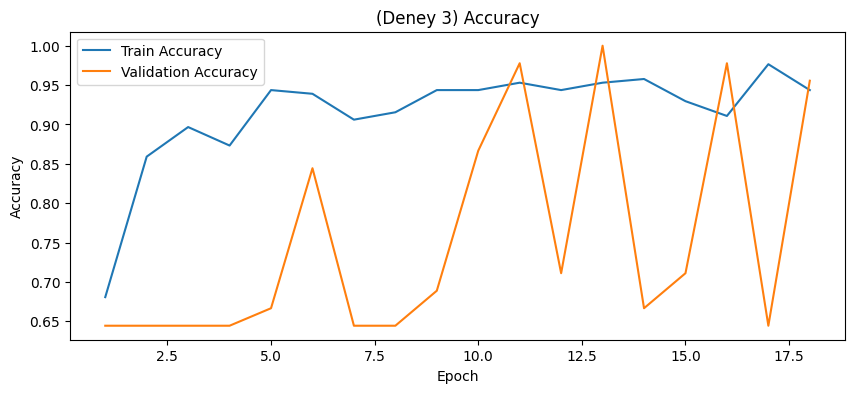

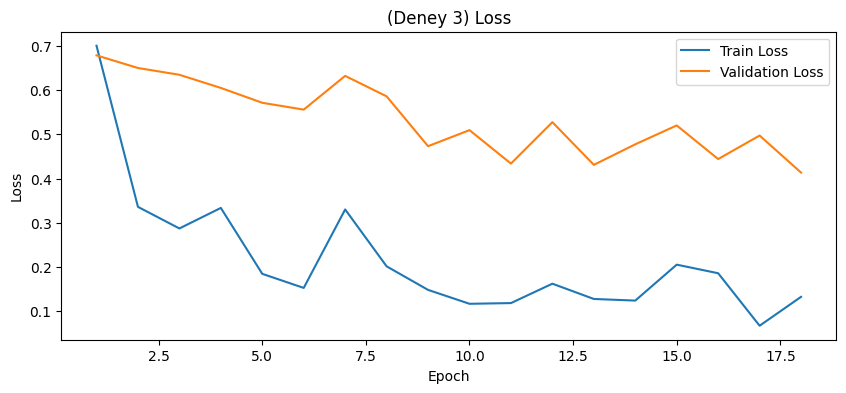

In [ ]:
import matplotlib.pyplot as plt

best_no = 3
h = histories[best_no].history #3. deneyin kayıtlarını alır.
epochs = range(1, len(h["accuracy"]) + 1) #1 den epoch sayısına kadar sayı yazar

plt.figure(figsize=(10,4))
plt.plot(epochs, h["accuracy"], label="Train Accuracy")
plt.plot(epochs, h["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("(Deney 3) Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(epochs, h["loss"], label="Train Loss")
plt.plot(epochs, h["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("(Deney 3) Loss")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model(best["model_path"])
print("En iyi model yüklendi (Deney 3)")

En iyi model yüklendi (Deney 3)


In [ ]:
best_batch = 32

test_gen_best = val_test_datagen.flow_from_directory(
    TEST,
    target_size=IMG_SIZE,
    batch_size=best_batch,
    class_mode="categorical",
    shuffle=False
)

loss, acc = best_model.evaluate(test_gen_best)
print("Model3 Best Test Accuracy:", acc)

Found 48 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9271 - loss: 0.4953
Model3 Best Test Accuracy: 0.9375


### Model3 – Hiperparametre Optimizasyonu Analizi

Model2 üzerine yapılan geliştirmelerde filtre sayısı, dropout oranı, batch size,
öğrenme oranı ve optimizer gibi hiperparametreler değiştirilmiştir.
Ayrıca ImageDataGenerator ile veri artırımı uygulanmıştır.

Deneyler sonucunda BatchNormalization ve GlobalAveragePooling kullanılan
mimari en yüksek test doğruluğunu (%93.75) sağlamıştır.
Büyük batch size (64) kullanılan deneylerde performansın düştüğü,
daha küçük batch size (32) ile daha iyi genelleme elde edildiği gözlemlenmiştir.

Veri artırımı ve mimari iyileştirmeler Model2’ye kıyasla performansı artırmıştır.


### 📷 Tek Görsel ile Tahmin
Aşağıdan bir ayakkabı veya bot fotoğrafı yükleyerek modelin tahminini görebilirsiniz.


In [ ]:
from tensorflow.keras.models import load_model
model = load_model(best["model_path"])

In [ ]:
from google.colab import files
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

uploaded = files.upload()

Saving IMG_1418.jpg to IMG_1418.jpg


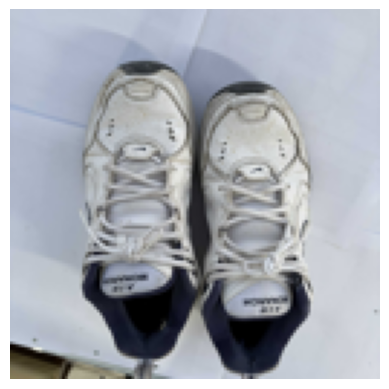

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
ayakkabi: %68.57
bot: %31.43

🟢 Tahmin: AYAKKABI (%68.57)


In [ ]:
# Yüklenen dosya adını al
img_path = list(uploaded.keys())[0]

# Görseli aç
img = Image.open(img_path).convert("RGB")
img = img.resize((128, 128))

# Görselleştir
plt.imshow(img)
plt.axis("off")
plt.show()

# Modele uygun hale getir
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Tahmin
pred = model.predict(img_array)[0]

# Sınıf isimleri (model1/model2/model3 hepsi için)
class_names = ["ayakkabi", "bot"]

# Yüzdeli sonuç
for i, cls in enumerate(class_names):
    print(f"{cls}: %{pred[i]*100:.2f}")

# En yüksek olasılık
predicted_class = class_names[np.argmax(pred)]
confidence = np.max(pred) * 100

print(f"\n🟢 Tahmin: {predicted_class.upper()} (%{confidence:.2f})")
